In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from keras.datasets import imdb

import numpy as np

import matplotlib.pyplot as plt

## Sequential class

### 학습 모델 설계

In [3]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784, )))
model.add(layers.Dense(10, activation='softmax'))

- 총 2개의 layer를 만든다.  
- 첫번째 layer는 총 32개의 노드를 가지고 있고, activation 함수로 relu를 사용한다. 그리고 입력값으로는 784 크기를 가진 1차원 배열을 받는다.(즉, 입력값이 784개 들어온다.)  
- 두번째 layer는 총 10개의 노드를 가지고 있고, 활성화 함수로 softmax를 사용한다. node의 개수가 10개인 이유는 output의 카테고리가 총 10개이기 때문이다.

### compile()
학습 모델의 optimizer, loss function, metrics를 configuration 해줌.

In [6]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='mse', metrics=['accuracy'])

해당 모델은 RMSprop 활성화 함수를 사용하고, 이때의 학습률은 0.001이다. 손실 함수로는 mse를 사용하고, 평가 지표로는 'accracy'를 사용해 단위는 %를 사용한다.

### fit() -> 모델 학습
학습 데이터를 이용해 모델을 학습시킨다. 이 때 parameter값으로 batch_size, epochs를 설정해준다.  
`epochs`  
전체 학습 데이터가 forward -> backpropagtion을 완료한 경우를 1번의 epochs라 한다.(=한 번의 최적화 과정을 거쳤다.)  
`batch_size`  
전체 학습 데이터의 크기가 클 때 batch_size만큼 데이터를 나눠서 학습한다.  
ex) data size=100, batch_size=10이라 하면 1번의 epochs가 수행되는데 총 10번의 iteration이 동작한다.

In [ ]:
model.fit(input데이터, target데이터, batch_size=128, epochs=10)

## IMDB
- 총 50,000개의 데이터, 25,000개는 train 데이터, 25,000개는 test 데이터  
- target 값은 0(부정)과 1(긍정) binary target

### Data load
num_words : 빈출 단어중 상위 10000개까지의 단어만 보여주겠다는 parameter.  
만약 10000이 넘어가는 단어가 등장하면 imdb.load_data의 parameter인 oov_char에 저장된 인덱스의 단어로 대체함.(default : 2)

In [129]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [130]:
word_index = imdb.get_word_index()
reverse_word_index = dict (
    [(value, key) for (key, value) in word_index.items()])

단어사전에서 0은 패딩, 1은 문서 시작, 2는 사전에 없음임. -> 그래서 oov_char의 default value가 2이다.  
따라서 진짜 해당 문장의 단어를 알기 위해서는 결과로 `저장된 단어 인덱스-3`을 해 줘야 한다.  

In [131]:
decoded_review = ' '.join(
    [reverse_word_index.get(i-3, '?') for i in train_data[11]])

In [132]:
decoded_review

"? when i rented this movie i had very low expectations but when i saw it i realized that the movie was less a lot less than what i expected the actors were bad the doctor's wife was one of the worst the story was so stupid it could work for a disney movie except for the murders but this one is not a comedy it is a laughable masterpiece of stupidity the title is well chosen except for one thing they could add stupid movie after dead husbands i give it 0 and a half out of 5"

### One-hot Encoding
- 문장 별로 총 단어사전의 단어 갯수만큼의 원소 갯수로 된 벡터를 만든다.  
- 만약에 해당 문장의 리스트가 [0, 3, 2, 6, 5, 5, 5, 5, 5, 5]라면 벡터에서 0, 2, 3, 5, 6 요소는 1, 나머지는 0으로 변환한다.  
- 즉, 벡터에서 해당 문장에 사용된 단어들만 1로 표시한다.

In [163]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### labels는 int형 -> float32형으로 타입변환

In [164]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Model Layer 만들기

In [165]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Train data를 validation data와 train data로 분리하기
Train data에 너무 최적화되도록 train 시키다 보면 train data에서만 예측이 잘 되는, 즉 `overfitting`된 결과를 얻게 된다.  
이를 대비하기 위해(=overfitting이 됐는지 확인하기 위해) train data를 validation data와 train data로 분리한다.  
train data로 fit을 한 후 validation data를 통해 overfitting이 발생했는지 검증한다.

In [166]:
x_val = x_train[:10000]    #검증데이터
partial_x_train = x_train[10000:]    #훈련데이터
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### train - compile()

In [167]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### train - fit()

In [146]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 62ms/step - loss: 0.5114 - acc: 0.7838 - val_loss: 0.3932 - val_acc: 0.8601
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.3096 - acc: 0.9019 - val_loss: 0.3051 - val_acc: 0.8861
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2249 - acc: 0.9283 - val_loss: 0.3404 - val_acc: 0.8588
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1784 - acc: 0.9425 - val_loss: 0.2743 - val_acc: 0.8900
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1414 - acc: 0.9577 - val_loss: 0.2858 - val_acc: 0.8849
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1188 - acc: 0.9635 - val_loss: 0.3029 - val_acc: 0.8828
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0953 - acc: 0.9723 - val_loss: 0.3090 - val_acc: 0.8841
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0792 - a

In [149]:
history_dict = history.history    #학습된 모델의 결과 정보를 담고 있는 dictionary
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### 학습된 결과 확인하기 - train_data와 validation_data의 결과를 비교해 overfitting이 발생하는지 확인
epochs이 20이기 때문에 총 각 key당 20개의 결과 데이터를 저장하고 있음.

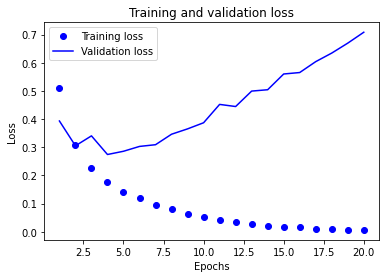

In [153]:
loss_values = history_dict['loss']    # train data의 loss
val_loss_values = history_dict['val_loss']    # validation data의 loss
epochs = range(1, len(history_dict['acc'])+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

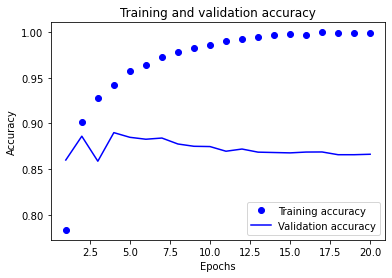

In [154]:
acc_values = history_dict['acc']    # train data의 acc
val_acc_values = history_dict['val_acc']    # validation data의 loss
epochs = range(1, len(history_dict['acc'])+1)

plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

확인 결과 epochs가 4를 넘어가는 순간 overfitting이 발생 -> `epochs=4로 수정`

In [172]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/4
30/30 [==============================] - 1s 37ms/step - loss: 0.5342 - accuracy: 0.7853 - val_loss: 0.4022 - val_accuracy: 0.8720
Epoch 2/4
30/30 [==============================] - 1s 22ms/step - loss: 0.3222 - accuracy: 0.9022 - val_loss: 0.3131 - val_accuracy: 0.8867
Epoch 3/4
30/30 [==============================] - 1s 22ms/step - loss: 0.2337 - accuracy: 0.9271 - val_loss: 0.2816 - val_accuracy: 0.8926
Epoch 4/4
30/30 [==============================] - 1s 20ms/step - loss: 0.1845 - accuracy: 0.9409 - val_loss: 0.2820 - val_accuracy: 0.8869


In [173]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

history = model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/4
30/30 [==============================] - 1s 46ms/step - loss: 0.5111 - binary_accuracy: 0.7967 - val_loss: 0.3858 - val_binary_accuracy: 0.8711
Epoch 2/4
30/30 [==============================] - 1s 35ms/step - loss: 0.3109 - binary_accuracy: 0.8963 - val_loss: 0.3119 - val_binary_accuracy: 0.8838
Epoch 3/4
30/30 [==============================] - 1s 24ms/step - loss: 0.2297 - binary_accuracy: 0.9247 - val_loss: 0.2806 - val_binary_accuracy: 0.8910
Epoch 4/4
30/30 [==============================] - 1s 24ms/step - loss: 0.1780 - binary_accuracy: 0.9413 - val_loss: 0.2738 - val_binary_accuracy: 0.8911


### Test data 학습시키기 - evaluate()

In [169]:
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.2996 - accuracy: 0.8783


In [170]:
model.predict(x_test)    #예측값 확인하기 - 예측값이 0에 가까울수록 부정, 1에 가까울수록 긍정

array([[0.2957167 ],
       [0.9994489 ],
       [0.8209836 ],
       ...,
       [0.10351074],
       [0.1374551 ],
       [0.5163687 ]], dtype=float32)